# Tutorial 5: Using the LDTk limb darkening model

**Author:** Hannu Parviainen <br>
**Edited:** 23 August 2024

The transit model used in EasyTS is extremely flexible in terms of what comes to the model used to represent the stellar limb darkening. The previous tutorials have used the two-parameter power-2 limb darkening model, and we can use any of the limb darkening models directly supported by the `pytransit.RRModel` or write our own, as explained in the `RRModel` documentation. 

However, a problem with these models is that they all add free parameters to the analysis. For example, in the case of the power-2 model, each limb darkening knot introduces two free parameters.

The `easyts.LDTkLD` limb darkening model offers an alternative approach that uses theoretical stellar atmosphere models directly. The model uses [LDTk](https://github.com/hpparvi/ldtk) to calculate the stellar intensity profiles for all the passbands from the stellar models and feeds the numerical intensity profiles to the transit model. The beauty of the approach is that `LDTkLD` is always parameterised by three parameters: the stellar effective temperature, log g, and metallicity. The downside, however, is that we are entirely dependent on the reliability of the stellar models, although the fact that we are marginalising over the stellar parameters should mitigate any dangers from this somewhat. 

Here we see how to use the `LDTkLD` model with `EasyTS`, and whether there are any differences with the power-2 model.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [33]:
from multiprocessing import Pool
from xarray import load_dataset
from numpy import array, geomspace, linspace
from matplotlib.pyplot import subplots, setp

from easyts import EasyTS, TSData, LDTkLD, load_model

## Data preparation

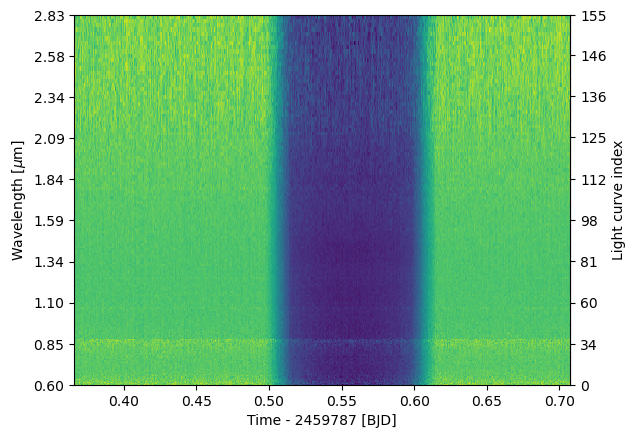

In [4]:
def read_data(fname):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values)

d1 = read_data('data/nirHiss_order_1.h5')
d1.remove_outliers()
d2 = read_data('data/nirHiss_order_2.h5')
d2.crop_wavelength(0.6, d1.wllims[0])
d2.remove_outliers()
db = d2.bin_wavelength(r = 100) + d1.bin_wavelength(r = 100)
ax = db.plot()

## Set up the LDTk limb darkening model

We initialise `LDTkLD` with the `TSData` data set, the stellar effective temperature, log g, and metallicity estimates as ($\mu$, $\sigma$) tuples, and the LDTk dataset to use. Here we choose to use the `visir-lowres` data that covers the wavelength range of 0.0525-5.4975 $\mu$m (52.5 - 5497.5 nm) with a resolution of 0.005 $\mu$m.

In [5]:
ldm = LDTkLD(db, teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), dataset='visir-lowres')

## Initialise EasyTS

Now, we initialise `EasyTS` giving it the `LDTkLD` instance as the limb darkening model, and then continue as usual. 

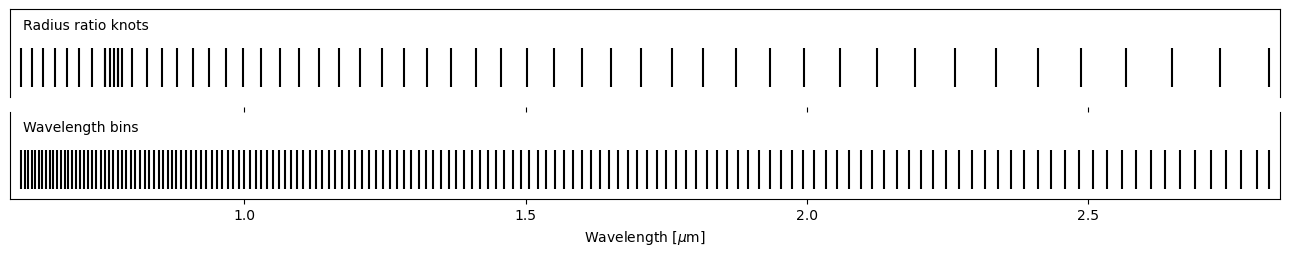

In [6]:
ts = EasyTS('01b_ldtk_limb_darkening', ldmodel=ldm, data=db, nk=50, nthreads=1)
ts.set_prior('tc', 'NP', 2459694.286, 0.003)
ts.set_prior('p', 'NP', 4.05487, 1e-5)
ts.set_radius_ratio_knots(geomspace(*ts.wavelength[[0, -1]], 50))
ts.add_radius_ratio_knots(linspace(0.768-0.015, 0.768+0.015, 5))
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.plot_setup();

Looking at the `EasyTS.plot_setup()` plot, we see that the limb darkening knots are not shown. This makes sense since the `LDTkLD` model works differently from the default limb darkening models. Let's take a look at the model parameterisation.

In [7]:
ts.ps

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 2459694.286, σ = 0.003)            [    -inf ..      inf],
   2 |G| p              N(μ = 4.05487, σ = 1e-05)                [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| teff           N(μ = 5327.0, σ = 139.0)                 [    0.00 ..      inf],
   7 |G| logg           N(μ = 4.38, σ = 0.09)                    [    0.00 ..      inf],
   8 |G| metal          N(μ = -0.01, σ = 0.1)                    [    -inf ..      inf],
   9 |G| k_00.60334     U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  10 |G| k_00.62263     U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  11 |G| k_00.64255  

The model parameterisation includes the three limb darkening model parameters, `teff`, `logg`, and `metal`, before the radius ratio knots, and nothing more. We've just removed 17 parameters from the model that used the power-2 limb darkening law with ten limb darkening knots!

The `LDTkLD` model calculates the stellar limb darkening profiles for all the passbands in the analysis given the stellar parameters. We can visualise the profiles using the `LDTkLD.plot_profiles` method. 

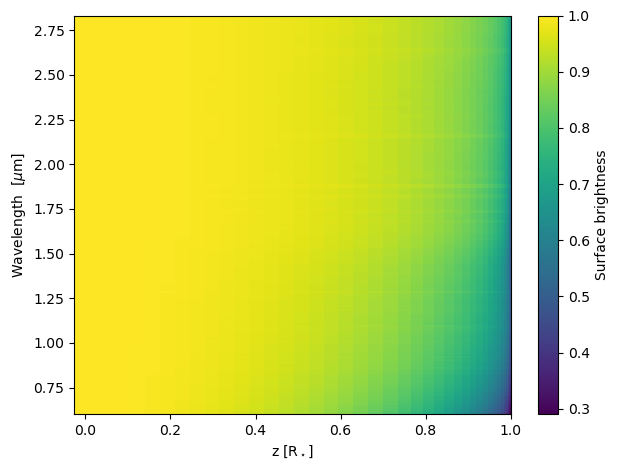

In [16]:
ts.ldmodel.plot_profiles(5327, -4.38, 0, x='z');

### Fit the white flux model

In [17]:
ts.fit_white()

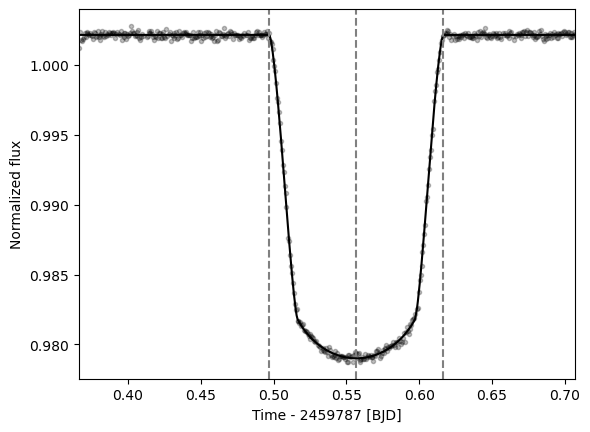

In [18]:
ax = ts.plot_white()

### Normalise the baseline

In [19]:
ts.normalize_baseline(1)

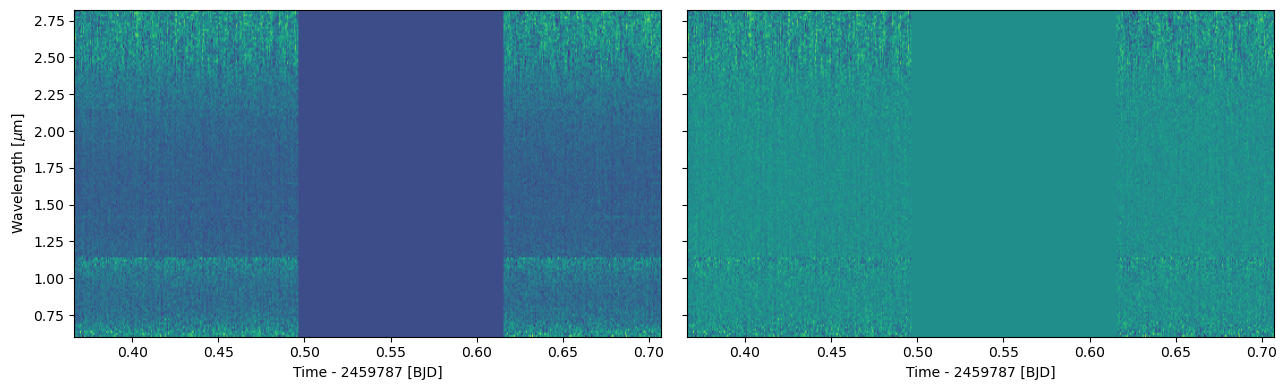

In [20]:
ts.plot_baseline();

In [21]:
ts.save(overwrite=True)

### Fit the transmission spectrum

In [22]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/2500 [00:00<?, ?it/s]

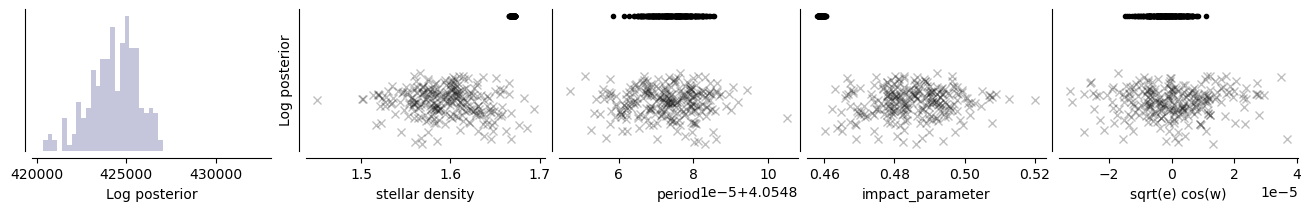

In [25]:
ts.fit(niter=2500, npop=250, pool=pool, lnpost=lnpostf)

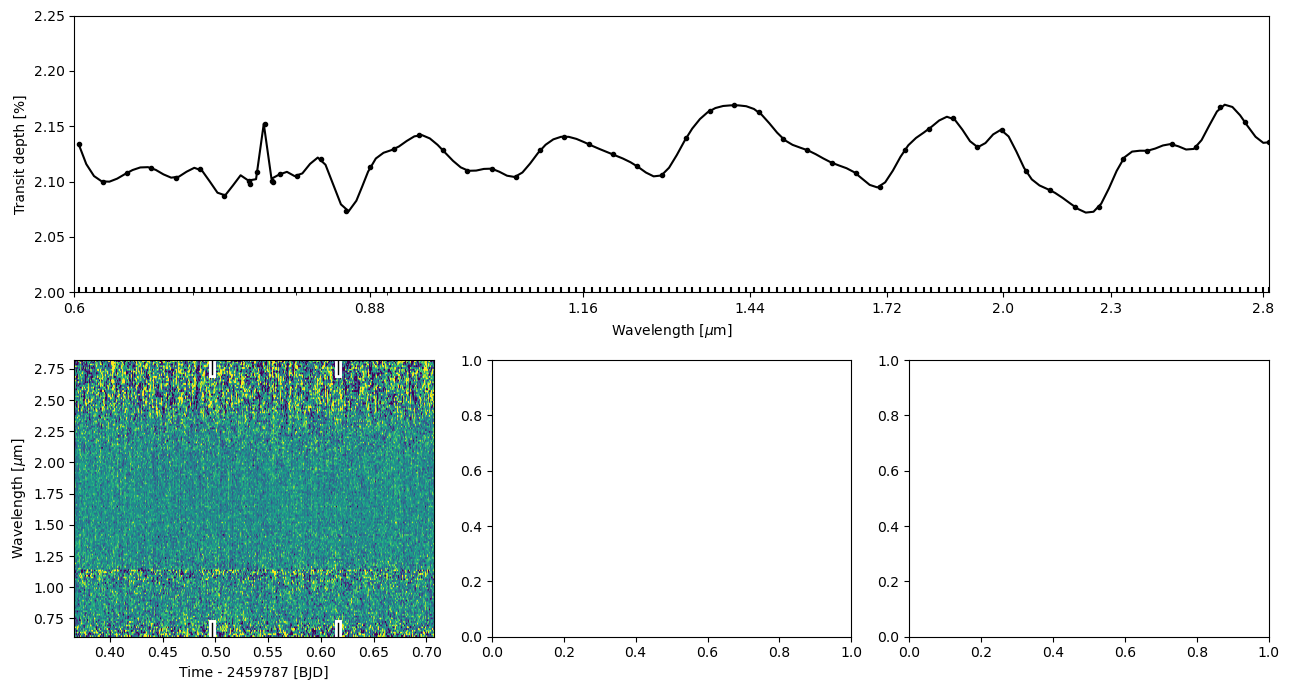

In [27]:
ts.plot_fit(result='fit', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### Save the optimisation results

In [28]:
ts.save(overwrite=True)

### MCMC sampling

In [64]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

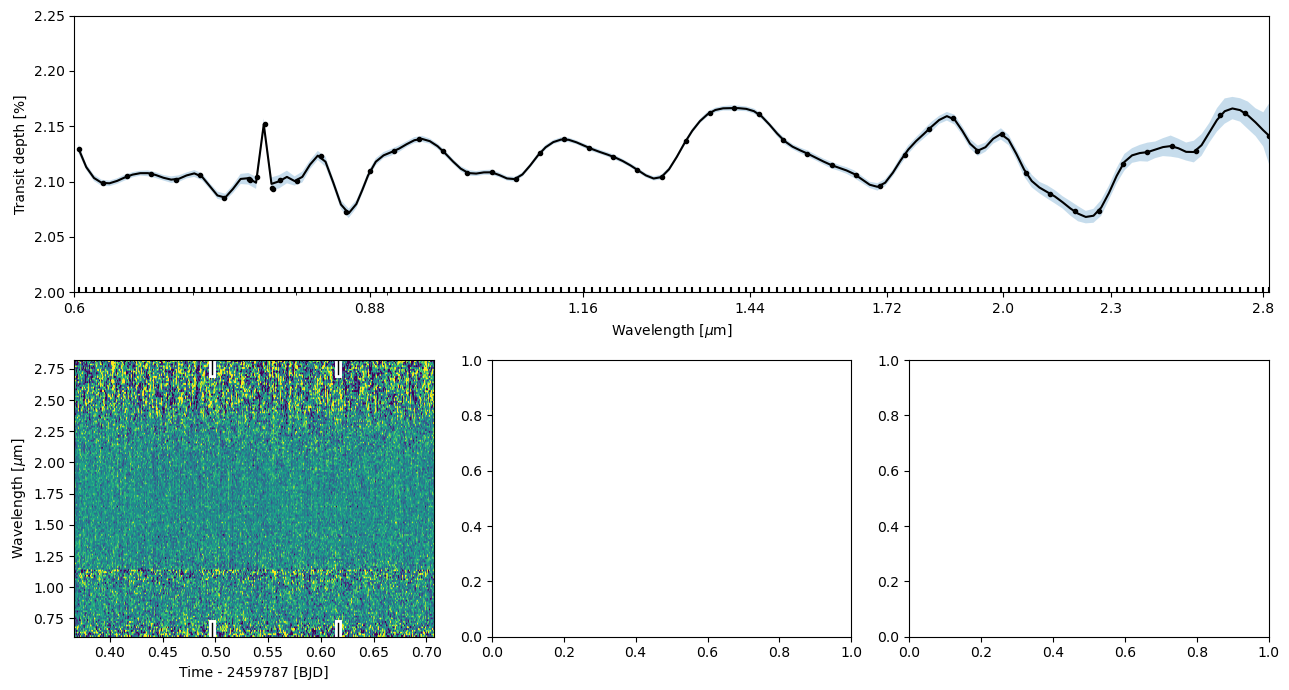

In [65]:
ts.plot_fit(result='mcmc', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### Save the results and compare with the power-2 model

In [66]:
ts.save(overwrite=True)

In [67]:
ts1 = ts.get_transmission_spectrum()
ts0 = load_model('01a_lowres_power2.fits').get_transmission_spectrum()

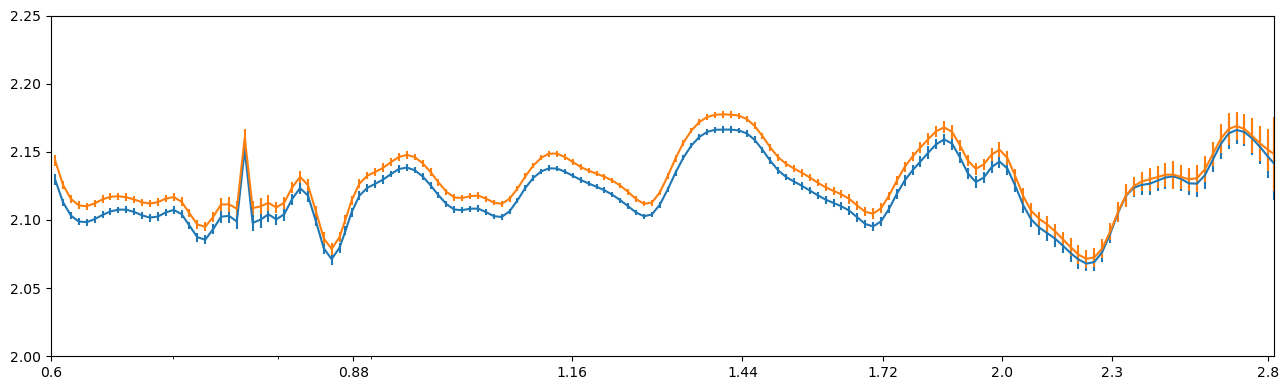

In [68]:
fig, ax = subplots(figsize=(13,4))
ax.errorbar(ts1.index, 1e2*ts1.depth, 1e2*ts1.depth_e)
ax.errorbar(ts0.index, 1e2*ts0.depth, 1e2*ts0.depth_e)
setp(ax, xlim=ts.wavelength[[0,-1]], xscale='log', ylim=(2.0,2.25))
xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]
ax.set_xticks(xticks, labels=xticks)
fig.tight_layout()

---

<center>&copy;2024 Hannu Parviainen</center>